## データオーグメンテーション（Data Augmentation）

**データオーグメンテーション** とは学習用データを擬似的に増やすことを指します。  

例えば「切り出し」、「反転」などを行うことによって、1 つの画像データから複数の画像データを生成します。  

データオーグメンテーションは実用上高い精度を得るうえで重要な工程です。 

データオーグメンテーションは画像認識（Computer Vision）に特化した Chainer の拡張ライブラリである `ChainerCV` を用いて簡単に実装できます。

ChainerCV は Google Colaboratory にデフォルトでは準備されていないため、まずは `pip` を使用してインストールを実行します。

In [2]:
!pip install chainercv

    100% |████████████████████████████████| 225kB 7.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/95/24/5a/1611db416857b5e092962bc22a70722315881e03970c7fa966
Successfully built chainercv


では、ChainerCV を用いて、画像データにどのような処理を加えることができるのか確認していきましょう。  

前回使用した画像（sample.png）を用いて、実装方法を見ていきます。

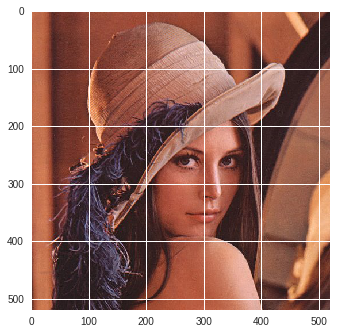

In [197]:
import chainer
import chainercv
import matplotlib.pyplot as plt
import numpy as np
from chainercv import transforms
from google.colab import drive
from PIL import Image

drive.mount('/content/drive/')
img_base = np.array(Image.open('drive/My Drive/Colab Notebooks/sample.png'))
plt.imshow(img_base)

### 代表的な画像データのオーグメンテーション手法

今回お伝えするのは代表的な下記の手法です。  

- random_crop：ランダムな位置で画像を切り出します
- random_flip：画像をランダムに上下左右反転します
- random_expand：画像の枠をランダムに広げます
- pca_lightning：色味を微妙に変化させます

この他にもいくつか手法があります。気になる方は[こちらのドキュメント](https://chainercv.readthedocs.io/en/stable/reference/transforms.html#image)をご確認ください。

画像がどのように変化するのか実際に確認してみます。

In [0]:
# ChainerCV を使用する際には画像はチャンネル、高さ、幅の形である必要があります
img = img_base.transpose(2, 0, 1)

In [201]:
img.shape

(3, 520, 520)

#### random_crop

In [0]:
# random_crop の適用
img_random_crop = transforms.random_crop(img, (224, 224)) 

In [203]:
img_random_crop.shape

(3, 224, 224)

では、画像がどのように変化しているのか確認してみましょう。  
実は Chainer の標準形式になっている画像は ChainerCV を使用すると簡単に可視化することができます。  

`chainercv.visualizations.vis_image(画像)` を使用して画像を表示します。

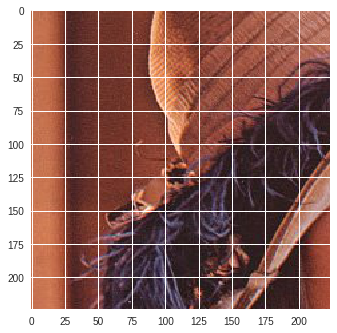

In [204]:
# Chainer 標準形式の画像の表示
chainercv.visualizations.vis_image(img_random_crop)

#### random_flip

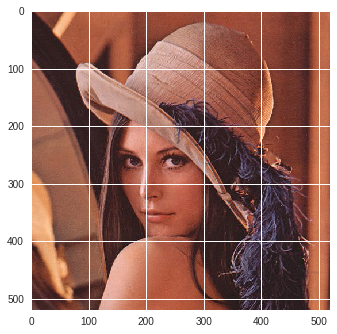

In [206]:
# random_flip の適用
img_random_flip = transforms.random_flip(img, x_random=True)
# Chainer 標準形式の画像の表示
chainercv.visualizations.vis_image(img_random_flip)

水平方向に反転するかしないかをランダムに決めているので、元と同じ画像が表示される場合もあります。

その場合は何度かこのセルを実行してみてください。

#### random_expand

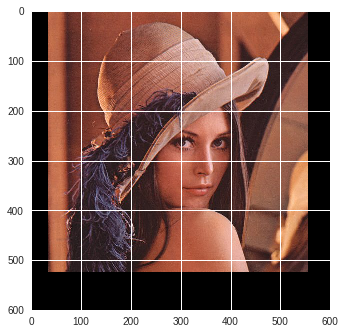

In [207]:
# random_expand の適用
img_random_expand = transforms.random_expand(img, max_ratio=1.5)
# Chainer 標準形式の画像の表示
chainercv.visualizations.vis_image(img_random_expand)

#### PCA Lightning

In [209]:
img.dtype  # データ型の確認

dtype('uint8')

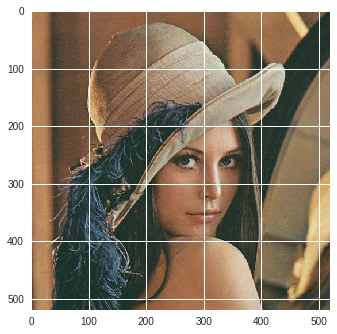

In [212]:
# PCA-lightning の適用
img_pca = transforms.pca_lighting(img.astype('f'), 76.5)
# Chainer 標準形式の画像の表示
chainercv.visualizations.vis_image(img_pca)

### データオーグメンテーションを用いての訓練

学習用データセットにデータオーグメンテーションを適用して、訓練を行います。 


#### データの準備：LabeledImageDataset の活用

データセットを準備する際、Chainer が用意している `LabeledImageDataset` を使用すればより簡単にラベルづけができます。  

今回はこの方法で画像データの準備を行います。  

`LabeledImageDataset` は `[(画像のファイルパス, ラベル), (画像のファイルパス, ラベル),,,]` のように、画像のファイルパスとラベルをタプルでまとめてリスト形式にしたものを受け取ります。  

In [156]:
from glob import glob
dog_filepaths = sorted(glob('drive/My Drive/Colab Notebooks/data/dog/*.jpg'))
cat_filepaths = sorted(glob('drive/My Drive/Colab Notebooks/data/cat/*.jpg'))
dog_filepaths[:5], cat_filepaths[:5]

(['drive/My Drive/Colab Notebooks/data/dog/0.jpg',
  'drive/My Drive/Colab Notebooks/data/dog/1.jpg',
  'drive/My Drive/Colab Notebooks/data/dog/109.jpg',
  'drive/My Drive/Colab Notebooks/data/dog/12.jpg',
  'drive/My Drive/Colab Notebooks/data/dog/123.jpg'],
 ['drive/My Drive/Colab Notebooks/data/cat/0.jpg',
  'drive/My Drive/Colab Notebooks/data/cat/1.jpg',
  'drive/My Drive/Colab Notebooks/data/cat/10.jpg',
  'drive/My Drive/Colab Notebooks/data/cat/100.jpg',
  'drive/My Drive/Colab Notebooks/data/cat/102.jpg'])

犬には `0` 、猫には `1` のラベルづけを行います。

In [0]:
labeled_images = []
for filepath in dog_filepaths:
    labeled_images.append((filepath, 0))
for filepath in cat_filepaths:
    labeled_images.append((filepath, 1))

上記のコードはPythonのリスト内包表記を使用して 1 行で書くことも可能です。  

```python
labeled_images = [(filepath, 0) for filepath in dog_filepaths] + [(filepath, 1) for filepath in cat_filepaths]

```

In [158]:
labeled_images[:5]

[('drive/My Drive/Colab Notebooks/data/dog/0.jpg', 0),
 ('drive/My Drive/Colab Notebooks/data/dog/1.jpg', 0),
 ('drive/My Drive/Colab Notebooks/data/dog/109.jpg', 0),
 ('drive/My Drive/Colab Notebooks/data/dog/12.jpg', 0),
 ('drive/My Drive/Colab Notebooks/data/dog/123.jpg', 0)]

In [12]:
len(labeled_images)

500

In [0]:
# LabeledImageDataset を作成
from chainer.datasets import LabeledImageDataset
dataset = LabeledImageDataset(labeled_images)

先ほどと比べると比較的簡単にデータセットを用意できました。  
では、実際にうまくデータセットの形式になっているのか確認しておきます。

In [56]:
len(dataset)

500

In [160]:
# データセットの 1 つ目を確認
dataset[0]

(array([[[127., 127., 114., ..., 166., 166., 167.],
         [102., 130., 131., ..., 168., 169., 171.],
         [136., 151., 136., ..., 168., 169., 169.],
         ...,
         [ 99.,  49., 111., ...,  62.,  17.,  81.],
         [ 61.,  33.,  86., ...,  41.,  20., 104.],
         [ 84.,  59.,  73., ...,  15.,   7.,  56.]],
 
        [[133., 138., 132., ..., 154., 154., 155.],
         [104., 138., 146., ..., 156., 157., 159.],
         [131., 151., 144., ..., 156., 157., 157.],
         ...,
         [108.,  60., 125., ...,  89.,  44., 109.],
         [ 70.,  43.,  99., ...,  68.,  47., 132.],
         [ 92.,  69.,  86., ...,  42.,  34.,  84.]],
 
        [[ 63.,  62.,  46., ..., 154., 154., 155.],
         [ 38.,  65.,  65., ..., 156., 157., 159.],
         [ 73.,  87.,  69., ..., 156., 157., 159.],
         ...,
         [ 53.,   4.,  66., ...,  36.,   0.,  51.],
         [ 17.,   0.,  43., ...,  15.,   0.,  74.],
         [ 41.,  16.,  32., ...,   0.,   0.,  26.]]], dtype=float32)

In [213]:
# チャンネル、高さ、幅の順になっている
dataset[0][0].shape

(3, 224, 224)

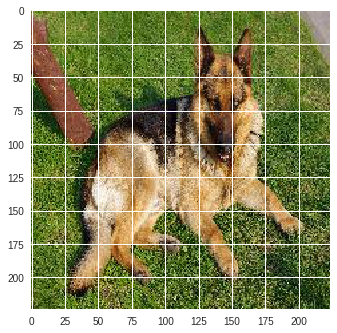

In [214]:
# 画像としてもうまく表示することが確認できます
chainercv.visualizations.vis_image(dataset[0][0])

### 学習用データセットと検証用データセットに分割

In [0]:
from chainer.datasets import split_dataset_random
n_train = int(len(dataset) * 0.7)
train_base, test_base = split_dataset_random(dataset, n_train, seed=1)

In [216]:
len(train)

350

In [217]:
len(test)

150

### TransformDataset を用いたデータセットの作成

Chainer ではデータオーグメンテーションをデータセットに対して適用する便利な方法が用意されています。

`TransformDataset` は、定義した処理をデータセット内の各データに対して実行してできる新しいデータセットを生成します。  

詳細は[公式のドキュメント](https://docs.chainer.org/en/stable/reference/generated/chainer.datasets.TransformDataset.html)を確認してください。

In [0]:
# 必要なモジュールのインポート
from chainer.datasets import TransformDataset
from functools import partial

画像の前処理の一種として標準化があります。  
基本的にニューラルネットワークのモデルでは入力の標準化が必須であり、画像処理においても標準化は重要な前処理です。  

まずそれぞれの画像のチャンネルごとの平均値と標準偏差を求めます。  

In [165]:
# axis 引数の 0, 2, 3 はそれぞれバッチ方向、高さ方向、幅方向の平均や標準偏差を求めることを意味します
mean = np.mean([x for x, _ in train_base], axis=(0, 2, 3))
std = np.std([x for x, _ in train_base], axis=(0, 2, 3))
mean, std

(array([126.37653, 118.11091, 101.86277], dtype=float32),
 array([67.195786, 65.558334, 67.87023 ], dtype=float32))

下記の `transforms` モジュールの関数でどのような前処理を加えるのかを定義しています。  

標準化の部分は平均値を引いて、標準偏差で割る処理を行なっています。  

なお、このコードは元画像のサイズがすべて 224 x 224 であることを前提に単純化しているので、別のデータの処理に流用する際には注意してください。

In [0]:
def transform(inputs, train=True):
    img, label = inputs
    
    # 訓練時のみ random flip & crop を適用
    if train:
        crop_size = round(224 * np.random.uniform(0.5, 1.0))
        img = transforms.random_crop(img, (crop_size, crop_size))
        img = transforms.random_flip(img, x_random=True)
        img = transforms.resize(img, (224, 224))

    # 画像の標準化
    img -= mean[:, None, None]
    img /= std[:, None, None]
        
    # 訓練時のみ PCA lightning を適用
    if train:
        img = transforms.pca_lighting(img, 0.1)

    return img, label

In [0]:
train = TransformDataset(train_base, partial(transform, train=True))
test = TransformDataset(test_base, partial(transform, train=False))  # 検証用データセットにはデータオーグメンテーションを適用しない

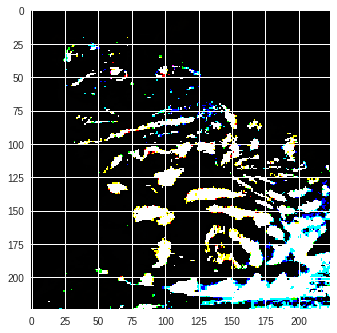

In [168]:
chainercv.visualizations.vis_image(train[0][0])

In [0]:
import chainer
import chainer.links as L

class VGG16(chainer.Chain):

    def __init__(self, n_out=9):
        super().__init__()
        with self.init_scope():
            self.base = L.VGG16Layers()
            self.fc = L.Linear(None, n_out)

    def __call__(self, x):
        h = self.base(x, layers=['fc7'])
        h = self.fc(h['fc7'])
        return h

In [0]:
# 乱数のシード固定用の関数
import random
def reset_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

In [0]:
# CPU と GPU 関連のシードをすべて固定
reset_seed(0)

In [0]:
# VGG16 モデルのインスタンス化
vgg16 = VGG16()
model = L.Classifier(vgg16)

In [174]:
gpu_id = 0  # 使用する GPU に割り振られている ID
model.to_gpu(gpu_id)

In [183]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [0]:
model.predictor.base.disable_update()

In [0]:
batchsize = 64
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [0]:
from chainer import training
from chainer.training import extensions

epoch = 30

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (epoch, 'epoch'), out='drive/My Drive/Colab Notebooks/result')

# 検証用のデータで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))

# 訓練の途中結果を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='dog-cat-augmentation.json'))

# １エポックごとに結果を log ファイルに出力させる
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/accuracy', 'validation/main/accuracy', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [188]:
trainer.run()

epoch       iteration   main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           6           0.424479       0.545928                  1.29254     0.67778               28.0441       
2           11          0.625          0.763731                  0.697545    0.510173              51.7907       
3           17          0.697917       0.830492                  0.621713    0.37441               79.6546       
4           22          0.746875       0.856061                  0.512598    0.35086               103.502       
5           28          0.820312       0.856534                  0.428158    0.324774              131.412       
6           33          0.803125       0.840436                  0.395249    0.360669              155.227       
7           39          0.838542       0.882102                  0.363518    0.31952               183.152       
8           44          0.809375       0.840436                  0.438809    0.348071     

In [0]:
import json
import pandas as pd
with open('drive/My Drive/Colab Notebooks/result/dog-cat-augmentation.json') as f:
    result = pd.DataFrame(json.load(f))

In [0]:
# 結果の表示
result.tail(10)

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
20,511.296763,21,115,0.871875,0.262260,0.907197,0.235840
21,537.642719,22,121,0.880208,0.321753,0.922348,0.239684
22,560.192309,23,126,0.887500,0.217871,0.897254,0.239714
23,586.570364,24,132,0.888021,0.248164,0.907197,0.255264
24,609.073856,25,137,0.878125,0.315034,0.860795,0.288077
25,635.441705,26,143,0.885417,0.277721,0.907197,0.242837
26,657.989213,27,148,0.896875,0.271344,0.892045,0.248379
27,684.351391,28,154,0.906250,0.238348,0.897254,0.242554
28,706.892434,29,159,0.903125,0.209551,0.897254,0.242222
29,733.284438,30,165,0.898438,0.243766,0.912405,0.235118


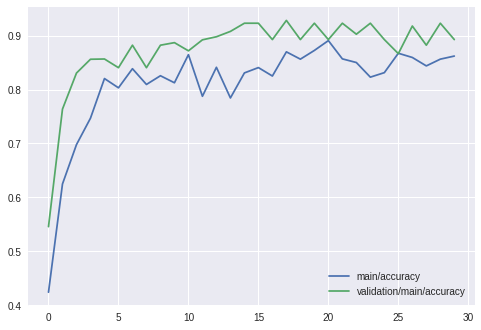

In [196]:
# 精度（accuracy）
result[['main/accuracy', 'validation/main/accuracy']].plot()

先ほどと比較しても結果は上昇していませんが、このデータオーグメンテーションはデータ数が少ない場合などに、 
大変有用な手法になるためぜひ覚えておいてください。  

本章ではどのように画像分類の問題設定で精度を向上させるかを確認しました。  

発展的な画像認識タスクである「物体検出」に入る前に、ChainerUI という、Chainer の学習中の内容を可視化、管理するパッケージについて解説します。